   HouseStyle_1.5Fin  HouseStyle_1.5Unf  HouseStyle_1Story  HouseStyle_2.5Fin  \
0               1306               1446                734               1452   
1                154                 14                726                  8   

   HouseStyle_2.5Unf  HouseStyle_2Story  HouseStyle_SFoyer  HouseStyle_SLvl  \
0               1449               1015               1423             1395   
1                 11                445                 37               65   

   Neighborhood_Blmngtn  Neighborhood_Blueste  ...  Neighborhood_NoRidge  \
0                  1443                  1458  ...                  1419   
1                    17                     2  ...                    41   

   Neighborhood_NridgHt  Neighborhood_OldTown  Neighborhood_SWISU  \
0                  1383                  1347                1435   
1                    77                   113                  25   

   Neighborhood_Sawyer  Neighborhood_SawyerW  Neighborhood_Somerst  \
0          

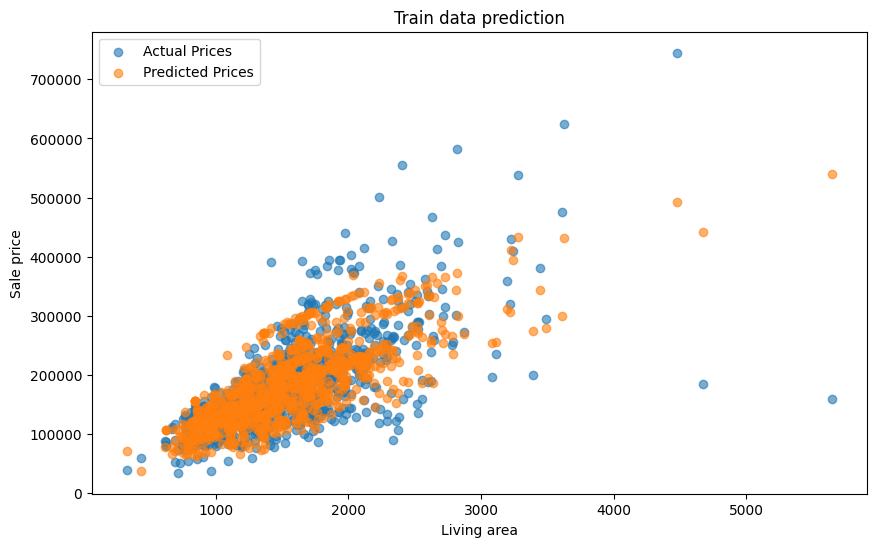

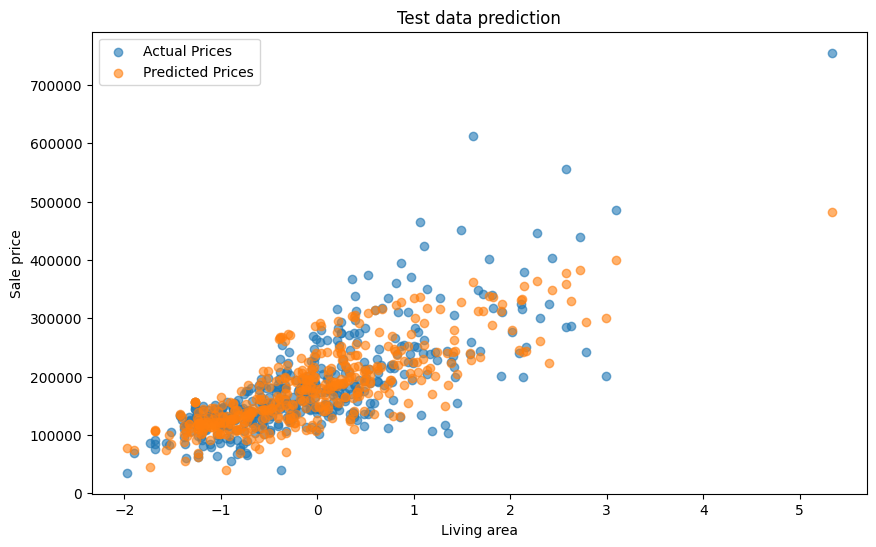

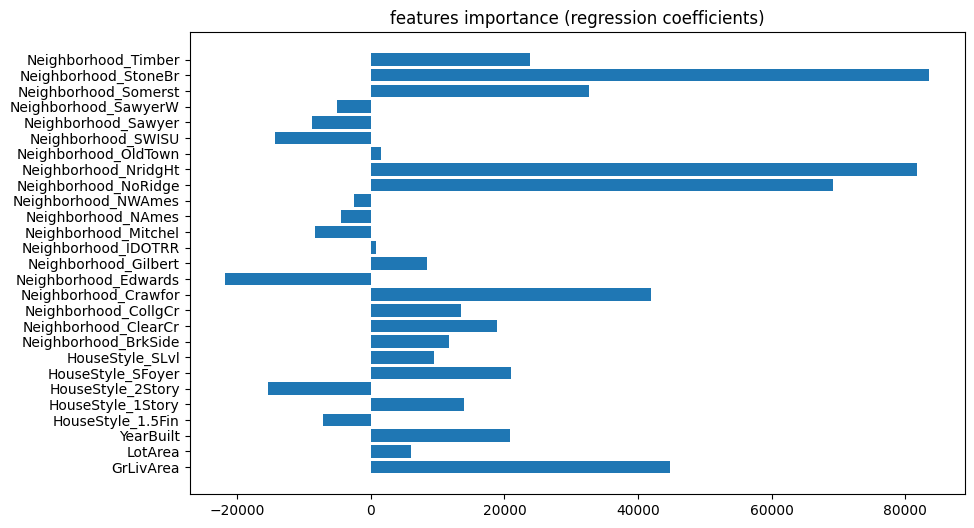

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load CSV containing housing prices into Pandas DataFrame
df = pd.read_csv("HousePrice.csv")

# # Get basic information about data
# print(df[["GrLivArea", "LotArea", "YearBuilt", "HouseStyle" , "Neighborhood", "SalePrice"]].info())        # display information about relevant columns
# print(df[["GrLivArea", "LotArea", "YearBuilt", "HouseStyle" , "Neighborhood", "SalePrice"]].head())        # display first 5 rows
# print(df[["GrLivArea", "LotArea", "YearBuilt", "HouseStyle" , "Neighborhood", "SalePrice"]].isna().sum())  # Check missing values, handle them (drop or impute) if exists

# group numeric and categorical features separately for preprocessing
numeric_cols     = ["GrLivArea", "LotArea", "YearBuilt"]
categorical_cols = ["HouseStyle", "Neighborhood"]

# print(df["HouseStyle"].value_counts())
# print(df["Neighborhood"].value_counts())

# Convert categorical features (HouseStyle & Neighborhood ) into one-hot encoded (dummy) numeric columns (0/1)
dummies_categorical_df = pd.get_dummies(df[categorical_cols], dtype=int, drop_first=True) # drop_first=True used to avoid multicollinearity

# print(dummies_categorical_df.head())
print(dummies_categorical_df.apply(pd.Series.value_counts))

for col in dummies_categorical_df.columns:
    if len(dummies_categorical_df[dummies_categorical_df[col] == 1]) < 20:
        dummies_categorical_df = dummies_categorical_df.drop(col, axis=1)


# Scale numeric feature columns using StandardScaler (returns a NumPy array without column names)
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df[numeric_cols]) # returns NumPy array

# Convert scaled numeric data to a DataFrame and preserve column names and index
scaled_numeric_df = pd.DataFrame(scaled_numeric, columns=numeric_cols, index=df.index)

# Extract features and response from DataFrame
X = pd.concat([scaled_numeric_df, dummies_categorical_df], axis=1)
y = df["SalePrice"]    

# Split data into train (70%) and test (30%) sets, random_state parameter makes the random split reproducible
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train the linear regression model on the training dataset
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

# Predict on train and test datasets
prediction_train = linreg_model.predict(X_train)
prediction_test = linreg_model.predict(X_test)

X_train_cont = scaler.inverse_transform(X_train.iloc[:, 0:3])
X_train_cont_df = pd.DataFrame(X_train_cont, columns=numeric_cols, index=X_train.index)
X_train = pd.concat([X_train_cont_df, X_train.iloc[:, 3:]], axis=1)

# Evaluate and display model accuracy with Mean Absolute Error for both train and test datasets
print(f"Mean absolute error in train dataset: {mean_absolute_error(y_train, prediction_train):.2f}")
print(f"Mean absolute error in test dataset: {mean_absolute_error(y_test, prediction_test):.2f}")

# Evaluate and display model accuracy with R2 Score for both train and test datasets
print(f"\nR2 score in train dataset: {r2_score(y_train, prediction_train):.2f}")
print(f"R2 score in test dataset: {r2_score(y_test, prediction_test):.2f}")

# Plot predictions vs actuals on train dataset
plt.figure(figsize=(10, 6))
plt.scatter(X_train["GrLivArea"], y_train, label="Actual Prices", alpha=0.6)
plt.scatter(X_train["GrLivArea"], prediction_train, label="Predicted Prices", alpha=0.6)
plt.title("Train data prediction")
plt.xlabel("Living area")
plt.ylabel("Sale price")
plt.legend(loc="upper left")
plt.show()

# Plot predictions vs actuals on test dataset
plt.figure(figsize=(10, 6))
plt.scatter(X_test["GrLivArea"], y_test, label="Actual Prices", alpha=0.6)
plt.scatter(X_test["GrLivArea"], prediction_test, label="Predicted Prices", alpha=0.6)
plt.title("Test data prediction")
plt.xlabel("Living area")
plt.ylabel("Sale price")
plt.legend(loc="upper left")
plt.show()

# Get regression coefficients of trained model
features_importance = linreg_model.coef_

# Create a list of all feature names corresponding to model coefficients
features = numeric_cols
for col in dummies_categorical_df.columns:
    features.append(col)

# Plot relative feature importance using absolute regression coefficients
plt.figure(figsize=(10, 6))
plt.barh(features, features_importance)
plt.title("features importance (regression coefficients)")
plt.show()